Hi all, welcome to another installment of working with DeepForest. Today we have some great data from Australian Eucalyptus forests. Let's walk through the steps to get some predictions. The first thing I did was look at the tile in QGIS to get a sense of the resolution (5cm), habitat type and image quality. Then I started with our standard boilerplate DeepForest prediction code from the 'Getting Started' page. In each of the code snippets below, I show the entire code used to create the output, which reflects what I'm really doing during debugging, which is trying a set of parameters, viewing the output and re-running.

In [ ]:
from deepforest import main
from matplotlib import pyplot as plt
m = main.deepforest()

m.use_release()
image = m.predict_tile(image="/Users/benweinstein/Downloads/Plot13Ortho.tif", patch_size=500, patch_overlap=0, return_plot=True)
plt.imshow(image[:,:,:3])

Here we get some error messages saying that the input raster image has four bands. This is pretty common for data that was exported from tools that create orthomosaics, like AgiSoft and Pix4d. Most programs have a toggle button for turning of the 'alpha channel'. We can use rasterio to open up the image and just select the bands we want.

Great, its starts to run, but wow that's going to take too long on CPU for me to write this post. On GPU this might only take 2mins, but with a CPU almost an hour according to progress bar. Kill that and let's come back to the full prediction set when we are happy.

## Crop a small portion to work with

Reading config file: /Users/benweinstein/.conda/envs/test/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


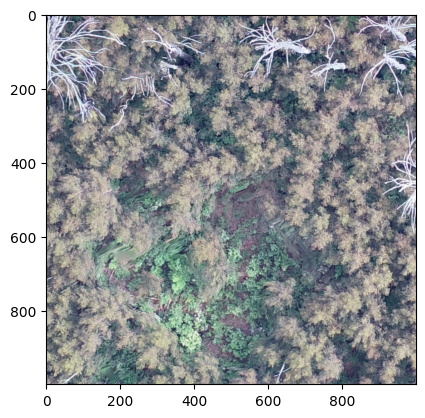

/Users/benweinstein/.conda/envs/test/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s]
215 predictions in overlapping windows, applying non-max supression
129 predictions kept after non-max suppression


/Users/benweinstein/.conda/envs/test/lib/python3.12/site-packages/deepforest/utilities.py:394: UserWarning: flip_y_axis is True, and projected is True. In most cases, projected should be False when inverting y axis. Setting projected=False
  warnings.warn(
/Users/benweinstein/.conda/envs/test/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/benweinstein/.conda/envs/test/lib/python3.12/site-packages/deepforest/visualize.py:126: UserWarning: No color was provided and the label column is not numeric. Using a single default color.
  warnings.warn("No color was provided and the label column is not numeric. "


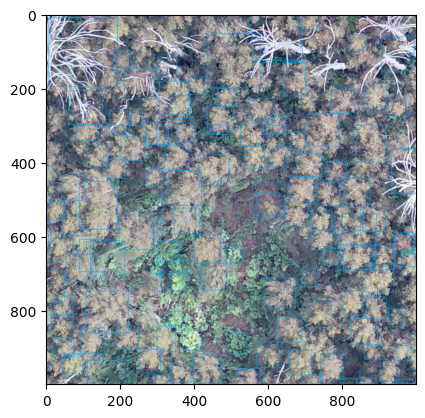

In [25]:
from deepforest import main
from deepforest import utilities
from deepforest import visualize
import rasterio as rio
from matplotlib import pyplot as plt
import cv2

m = main.deepforest()
m.use_release()
# Make into a 3 page, remove alpha channel, and make channels last
r = rio.open("/Users/benweinstein/Downloads/Plot13Ortho.tif").read()
r = r[:3,:,:]
r = r.transpose(1,2,0)

#Grab a portion of image just to test, near the middle
r = r[12000:13000,6000:7000,:]
plt.imshow(r)
plt.show()

# save the image as numpy array
cv2.imwrite("/Users/benweinstein/Downloads/Plot13Ortho_crop.tif", r)
m.config
boxes = m.predict_tile(image=r, patch_size=700, patch_overlap=0.2, iou_threshold=0.5)
boxes["image_path"] = "Plot13Ortho_crop.tif"
gdf = utilities.boxes_to_shapefile(boxes, root_dir="/Users/benweinstein/Downloads", flip_y_axis=True)
gdf.to_file("/Users/benweinstein/Downloads/Plot13Ortho_crop.shp")

plot = visualize.plot_predictions(image=r, df=gdf)
plt.imshow(plot)
plt.show()

This is a decent start for zero-shot imagery in a new resolutions. Let's try a couple things. To see if we can make it any better without new annotations. We always say that DeepForest is best used as a backbone, and an hour of new annotation on target imagery and gentle finetuning will produce better results than changing.  hyperparameters. 

# Make geospatial predictions on the full tile

Now that i'm happy with a small crop, I want to make predictions on the entire image.